In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from numpy import load
import numpy

data = load('/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

edges
[[    0 18427]
 [18427     0]
 [    1 21708]
 ...
 [ 5563  5563]
 [22425 22425]
 [22425 22425]]
features
[[-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.36413375
  -0.12863389]
 [-0.26257643 -0.26505256 -0.26235026 ... -0.21514018 -0.3759032
  -0.22383557]
 ...
 [-0.26257643 -0.27648264 -0.26235026 ... -0.18038896 -0.37209702
  -0.22261272]
 [-0.26257643 -0.27648264 -0.26235026 ... -0.21514018 -0.3759032
  -0.21814811]
 [-0.23227507 -0.27648264 -0.26235026 ... -0.19585785 -0.3759032
  -0.2212746 ]]
target
[0 2 1 ... 2 1 0]


In [2]:
!unzip -o -q "/content/drive/MyDrive/Colab Notebooks/FacebookNetworkGCN/PatternFlow/recognition/FacebookNetworkGCN/facebook_large.zip"

In [3]:
ls facebook_large

citing.txt                musae_facebook_features.json  README.txt
musae_facebook_edges.csv  musae_facebook_target.csv


In [3]:
import os
import pandas as pd
import networkx as nx
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Initialise the data

In [64]:
data_dir = pathlib.Path("facebook_large/")

"""edges = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_edges.csv"),
    sep=",",
    header=0,
    names=["target", "source"],
)
"""

edges = data["edges"]

edges = pd.DataFrame(data=edges, columns=["source", "target"])

print("Edges shape:", edges.shape)

Edges shape: (342004, 2)


In [65]:
edges.sample(frac=1).head()

,source,target
316089,20927,16303
232351,10370,9744
328003,21729,17848
125926,4534,21117
316449,5978,16345


In [66]:
"""pages = pd.read_csv(
    os.path.join(data_dir, "musae_facebook_target.csv"), 
    sep=","
)
"""

id = numpy.arange(22470)

id = pd.DataFrame(data=id)

categories = data["target"]

categories = pd.DataFrame(data=categories)

pages = data["features"]

pages = pd.DataFrame(data=pages)

pages = numpy.concatenate((id, pages, categories), axis=1)

row_names = ["id"] + [f"term_{idx}" for idx in range(128)] + ["category"]

pages = pd.DataFrame(data=pages, columns=row_names)

print("Pages shape:", pages.shape)

Pages shape: (22470, 130)


In [67]:
print(pages.sample(5).T)

                4540         2566          14112         11074         12004
id        4540.000000  2566.000000  14112.000000  11074.000000  12004.000000
term_0      -0.262576    -0.260148     -0.262576     -0.262576     -0.262576
term_1      -0.276483    -0.276483     -0.276483     -0.276483      3.097373
term_2      -0.262350    -0.249978     -0.262350     -0.262350     -0.243942
term_3      -0.299327    -0.299327     -0.299327     -0.299327     -0.299327
...               ...          ...           ...           ...           ...
term_124    -0.255755    -0.255755     -0.255755     -0.255755     -0.223287
term_125    -0.215140    -0.215140     -0.215140     -0.027965     -0.201136
term_126    -0.375903    -0.375903     -0.375903     -0.375903     -0.375903
term_127    -0.223836    -0.223836     -0.223836     -0.036616     -0.223836
category     2.000000     2.000000      0.000000      2.000000      3.000000

[130 rows x 5 columns]


In [68]:
print(pages.category.value_counts())

2.0    6880
1.0    6495
3.0    5768
0.0    3327
Name: category, dtype: int64


In [69]:
class_values = sorted(pages["category"].unique())
class_idx = {name: idy for idy, name in enumerate(class_values)}
page_idx = {name: idx for idx, name in enumerate(sorted(pages["id"].unique()))}

pages["id"] = pages["id"].apply(lambda name: page_idx[name])
edges["source"] = edges["source"].apply(lambda name: page_idx[name])
edges["target"] = edges["target"].apply(lambda name: page_idx[name])
pages["category"] = pages["category"].apply(lambda value: class_idx[value])

Visualise the graph

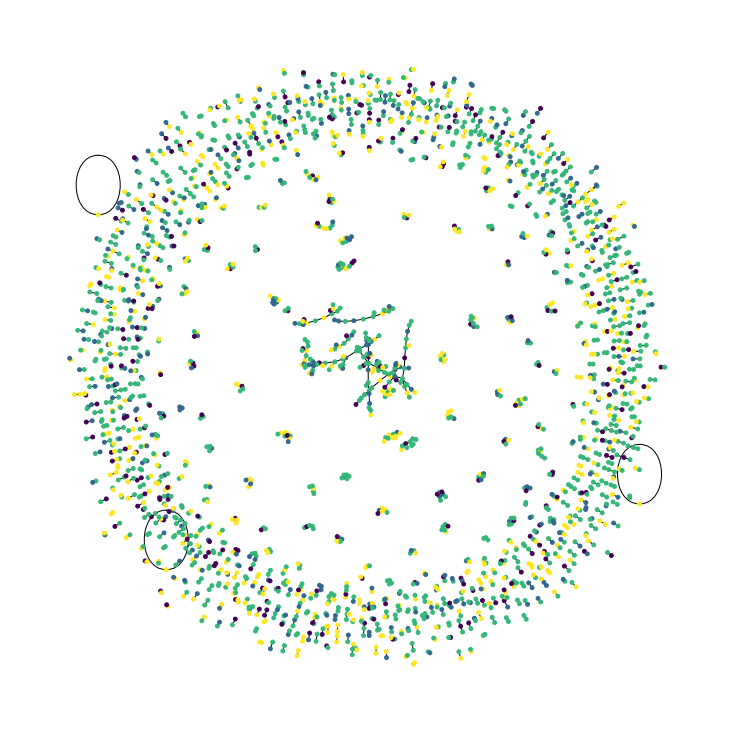

In [71]:
plt.figure(figsize=(10, 10))
colours = pages["category"].tolist()
fb_graph = nx.from_pandas_edgelist(edges.sample(n=1500))
page_type = list(pages[pages["id"].isin(list(fb_graph.nodes))]["category"])
nx.draw_spring(fb_graph, node_size=15, node_color=page_type)

Split the data into train and test data sets

In [72]:
train_data, test_data = [], []

for _, grouped_data in pages.groupby("category"):
    train_data.append(grouped_data[:len(grouped_data.index)//2])
    test_data.append(grouped_data[len(grouped_data.index)//2:])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (11234, 130)
Test data shape: (11236, 130)


In [74]:
feature_names = set(pages.columns) - {"id", "category"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a tensor.
x_train = tf.convert_to_tensor(train_data[feature_names])
x_test = tf.convert_to_tensor(test_data[feature_names])
# Create train and test targets as a tensor.
y_train = train_data["category"]
y_test = test_data["category"]

In [75]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [76]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation='relu'))
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation='relu'))
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
        fnn_layers.append(layers.BatchNormalization())

    return keras.Sequential(fnn_layers, name=name)

In [77]:
hidden_units = [128, 128]
learning_rate = 0.001
dropout_rate = 0.05
num_epochs = 300
batch_size = 512

In [78]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 128)          103168      input_features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 128)          103168      ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection2 (Add)          (None, 128)          0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [79]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
19/19 [==============================] - 15s 174ms/step - loss: 2.6826 - acc: 0.2967 - val_loss: 1.3693 - val_acc: 0.2711
Epoch 2/300
19/19 [==============================] - 2s 122ms/step - loss: 2.0509 - acc: 0.3381 - val_loss: 1.3598 - val_acc: 0.3642
Epoch 3/300
19/19 [==============================] - 2s 117ms/step - loss: 1.7826 - acc: 0.3648 - val_loss: 1.3438 - val_acc: 0.3648
Epoch 4/300
19/19 [==============================] - 2s 119ms/step - loss: 1.6207 - acc: 0.3842 - val_loss: 1.3256 - val_acc: 0.3849
Epoch 5/300
19/19 [==============================] - 2s 119ms/step - loss: 1.5138 - acc: 0.4056 - val_loss: 1.2999 - val_acc: 0.3808
Epoch 6/300
19/19 [==============================] - 2s 121ms/step - loss: 1.4203 - acc: 0.4316 - val_loss: 1.2767 - val_acc: 0.3921
Epoch 7/300
19/19 [==============================] - 2s 118ms/step - loss: 1.3432 - acc: 0.4473 - val_loss: 1.2241 - val_acc: 0.4454
Epoch 8/300
19/19 [==============================] - 2s 118ms/step -

In [81]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.94%
